# Data preparation for CellOracle analysis of Trevino *et al.*

In [1]:
import os

### **`DOWNLOAD DATA`**

In [2]:
download_dir = '/scratch/xoel/mar-09/raw/'
dest_dir = 'Trevino2019'
final_dir = '/users/genomics/xoel/codebases/co_new/raw/'
log_dir = '/users/genomics/xoel/codebases/co_new/logs/'
trevino_dir = f'{final_dir}{dest_dir}/'

os.makedirs(download_dir, exist_ok=True)
os.makedirs(final_dir, exist_ok=True)
os.makedirs(log_dir, exist_ok=True)
os.chdir(download_dir)

In [3]:
!ls ./ -Rla

./:
total 0
drwxr-xr-x 2 xoel ng  6 May 26 23:35 .
drwxr-xr-x 3 xoel ng 17 May 26 23:35 ..


In [4]:
# !rm -rf *

The data divisions come from two observations:
 - Patient-bias: many cell types show huge bias towards restricted patients,
 - Cell-types: we observe cell types undergoing RGC maturation, neurogenesis and gliogenesis

Based on these, we want to split the dataset in the 3 different processes. since we have a big number of neurons in each patient, we will run the analysis of neurogenesis per donor.


In [5]:
def unique(x):
    return list(dict.fromkeys(x))

Also, we delete duplicated gene symbols and use symbols as the gene identifier.

In [6]:
import os
import sys
import gc

import numpy as np
import pandas as pd

In [7]:
import scanpy as sc
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [8]:
os.chdir('/users/genomics/xoel/codebases/co_new/data/')

# **RNA //** Cell metadata

In [9]:
# Load cell metadata from reannotation pipe
cell_metadata = pd.read_csv('~/codebases/scvi/data/RGC_reannotation.full_meta.tsv', sep='\t').set_index('Cell.ID', drop=False)
cell_metadata

Cell.ID      Sample.ID  \
Cell.ID                                                                         
hft_w20_p3_r1_AAACCCAAGCTGCGAA  hft_w20_p3_r1_AAACCCAAGCTGCGAA  hft_w20_p3_r1   
hft_w20_p3_r1_AAACCCAAGGTAGTAT  hft_w20_p3_r1_AAACCCAAGGTAGTAT  hft_w20_p3_r1   
hft_w20_p3_r1_AAACCCACAACTCCAA  hft_w20_p3_r1_AAACCCACAACTCCAA  hft_w20_p3_r1   
hft_w20_p3_r1_AAACCCACATAGTCAC  hft_w20_p3_r1_AAACCCACATAGTCAC  hft_w20_p3_r1   
hft_w20_p3_r1_AAACCCAGTACAGGTG  hft_w20_p3_r1_AAACCCAGTACAGGTG  hft_w20_p3_r1   
...                                                        ...            ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA  hft_w16_p7_r2_TTTGTTGCAGCACCCA  hft_w16_p7_r2   
hft_w16_p7_r2_TTTGTTGCAGGCTACC  hft_w16_p7_r2_TTTGTTGCAGGCTACC  hft_w16_p7_r2   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA  hft_w16_p7_r2_TTTGTTGGTCGCTTAA  hft_w16_p7_r2   
hft_w16_p7_r2_TTTGTTGGTCGTACAT  hft_w16_p7_r2_TTTGTTGGTCGTACAT  hft_w16_p7_r2   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG  hft_w16_p7_r2_TTTGTTGGTTAGTTCG  hft_w16_p7_r2   

                                  Age Tissue.ID Sample.Type   Assay     Batch  \
Cell.ID                                                                         
hft_w20_p3_r1_AAACCCAAGCTGCGAA  pcw20      HFT3         HFT  RNA v3  b2019_06   
hft_w20_p3_r1_AAACCCAAGGTAGTAT  pcw20      HFT3         HFT  RNA v3  b2019_06   
hft_w20_p3_r1_AAACCCACAACTCCAA  pcw20      HFT3         HFT  RNA v3  b2019_06   
hft_w20_p3_r1_AAACCCACATAGTCAC  pcw20      HFT3         HFT  RNA v3  b2019_06   
hft_w20_p3_r1_AAACCCAGTACAGGTG  pcw20      HFT3         HFT  RNA v3  b2019_06   
...                               ...       ...         ...     ...       ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA  pcw16      HFT7         HFT  RNA NG  b2020_03   
hft_w16_p7_r2_TTTGTTGCAGGCTACC  pcw16      HFT7         HFT  RNA NG  b2020_03   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA  pcw16      HFT7         HFT  RNA NG  b2020_03   
hft_w16_p7_r2_TTTGTTGGTCGTACAT  pcw16      HFT7         HFT  RNA NG  b2020_03   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG  pcw16      HFT7         HFT  RNA NG  b2020_03   

                               seurat_clusters  RNA.Counts  RNA.Features  ...  \
Cell.ID                                                                   ...   
hft_w20_p3_r1_AAACCCAAGCTGCGAA             c16        1397           677  ...   
hft_w20_p3_r1_AAACCCAAGGTAGTAT             c11       14338          4301  ...   
hft_w20_p3_r1_AAACCCACAACTCCAA             c17        9260          3481  ...   
hft_w20_p3_r1_AAACCCACATAGTCAC              c0        4025          1969  ...   
hft_w20_p3_r1_AAACCCAGTACAGGTG              c4        7131          2930  ...   
...                                        ...         ...           ...  ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA              c6        8532          3497  ...   
hft_w16_p7_r2_TTTGTTGCAGGCTACC              c2        6689          2393  ...   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA              c2        3865          1799  ...   
hft_w16_p7_r2_TTTGTTGGTCGTACAT              c2        5293          2365  ...   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG              c6        5291          2530  ...   

                                G2M_score  phase n_genes_by_counts  \
Cell.ID                                                              
hft_w20_p3_r1_AAACCCAAGCTGCGAA  -0.057635     G1             677.0   
hft_w20_p3_r1_AAACCCAAGGTAGTAT  -0.574498     G1            4301.0   
hft_w20_p3_r1_AAACCCACAACTCCAA  -0.648533     G1            3481.0   
hft_w20_p3_r1_AAACCCACATAGTCAC  -0.198140     G1            1969.0   
hft_w20_p3_r1_AAACCCAGTACAGGTG  -0.455186     G1            2930.0   
...                                   ...    ...               ...   
hft_w16_p7_r2_TTTGTTGCAGCACCCA  -0.400439     G1            3497.0   
hft_w16_p7_r2_TTTGTTGCAGGCTACC  -0.250289     G1            2393.0   
hft_w16_p7_r2_TTTGTTGGTCGCTTAA  -0.232386     G1            1799.0   
hft_w16_p7_r2_TTTGTTGGTCGTACAT  -0.208882     G1            2365.0   
hft_w16_p7_r2_TTTGTTGGTTAGTTCG  -0.223319     G1     

## Updated annotation

In [10]:
# Dictionary of cell types selected for reannotation
nesc_clusters = {
    'Cycling Progenitor': True,
    'Early Radial Glia': True,
    'Late Radial Glia': True,
    'Truncated Radial Glia': True,
    'Multipotent glial progenitor cell': True,
    'Oligodendrocyte Progenitor Cell/Oligodendrocyte': True,
    'neuronal intermedate progenitor cell': True,
    'Glutamatergic Neuron 1': False,
    'Glutamatergic Neuron 2': False,
    'Glutamatergic Neuron 3': False,
    'Glutamatergic Neuron 4': False,
    'Glutamatergic Neuron 5': False,
    'Glutamatergic Neuron 6': False,
    'Glutamatergic Neuron 7': False,
    'Glutamatergic Neuron 8': False,
    'Subplate': False,
    'CGE Interneuron': False,
    'MGE Interneuron': False,
    'Microglia': False,
    'Pericyte': False,
    'Endothelial Cell': False,
    'Red Blood Cell': False,
    'Vascular and Leptomeningeal Cell': False
}

final_labels = {
    'vRG E': 'vRG E',
    'vRG L': 'vRG L',
    'tRG': 'tRG',
    'tRG EOMES+': 'tRG',
    'oRG E': 'oRG E',
    'oRG L': 'oRG L',
    
    'mGPC': 'mGPC',
    'Astro': 'Astro',
    'OPC': 'OPC',
    'Oligo': 'OPC',

    'Neu': 'nIPC',
    'nIPC': 'nIPC',
    'Neu E': 'Neu E',

    'GluN1': 'GluN1',
    'GluN2': 'GluN2',
    'GluN3': 'GluN3',
    'GluN4': 'GluN4',
    'GluN5': 'GluN5',
    'GluN6': 'GluN6',
    'GluN7': 'GluN7',
    'GluN8': 'GluN8',

}

len(set(final_labels.values()))


18

In [11]:
palette_fname='../results/CellTypeColor.csv'
if os.path.exists(palette_fname):
    palette = {k: v for k, v in pd.read_csv(palette_fname).set_index('Name').iloc[:,0].to_dict().items() if k in final_labels.values()}
else: 
    palette = dict(zip(
        set(final_labels.values()), # labels
        sc.pl.palettes.default_20[:len(set(final_labels.values()))])) # colors

ordered_types = [ 
    'vRG E',
    'vRG L',
    'tRG',
    'tRG EOMES+',
    'Epen',
    'oRG E',
    'oRG L',
    'nIPC',
    'Neu E',
    'IN',
    'mGPC',
    'Astro',
    'OPC',
    'Oligo',
    'LQ RGC'
]


final_type_palette = {'Neu': palette['nIPC']}
final_type_palette.update(palette)

clusters_palette = {'Cyc. Prog.':'#EFDC60','Early RG':'#FEA090','Late RG':'#E0607E','tRG':'#8E2043','nIPC':'#0A9086','mGPC':'#59C7EB','OPC/Oligo':'#3E5496'}
clusters_palette.update(palette)

Create a table for annotations and palette, and merge it with metadata

In [12]:
reannot_table = pd.DataFrame({
    'reannotated type': cell_metadata[['rgcs_id', 'nesc_id']].apply(lambda x: np.nan if x.isna().all() else x[~x.isna()][0], axis=1),
    'was reannot': cell_metadata['Cluster.LongName'].astype(str).replace(nesc_clusters),
    'original type': cell_metadata['cell.type']
    }, index=cell_metadata.index)
reannot_table['Selected for reannotation'] = reannot_table['was reannot'].astype('category')
reannot_table['failed reannot'] = (reannot_table['reannotated type'].isna() & reannot_table['was reannot'])

reannot_table['final type'] = np.where(
    reannot_table['was reannot'],
    reannot_table['reannotated type'],
    reannot_table['original type']
)

reannot_table['final.label'] = pd.Categorical(np.where(
    reannot_table['final type'].isin(final_labels.keys()),
    reannot_table['final type'].replace(final_labels),
    np.nan), categories=unique(final_labels.values()))

reannot_table['label.color'] = reannot_table['final.label'].replace(palette)

# I made a mistake and called NEU the cluster of NIPC during annotation
reannot_table['final type'] = reannot_table['final type'].replace('Neu', 'nIPC')


In [13]:
reannot_table['final type'][
    reannot_table['final.label'].isna() & reannot_table['final type'].isin(final_labels.keys())]

Series([], Name: final type, dtype: object)

This is the number of cells per final class

In [14]:
reannot_table['final type'].value_counts().sort_index()

Astro           884
CGE_IN         5510
EC              273
Epen             52
GluN1          4984
GluN2          3784
GluN3          2685
GluN4          3954
GluN5         11367
GluN6          1627
GluN7          2703
GluN8          1210
IN               64
LQ RGC          200
MG              944
MGE_IN         4337
Neu E           790
OPC             597
Oligo            92
Peric.          448
RBC              45
SP             1333
VLMC             30
mGPC           1800
nIPC           2483
oRG E          1784
oRG L          1479
tRG             426
tRG EOMES+      147
vRG E           682
vRG L           622
Name: final type, dtype: int64

This is the number of cells that we discarded during annotation 

In [15]:
reannot_table['original type'][reannot_table['failed reannot']].value_counts()

Early_RG      212
OPC_Oligo     151
mGPC           76
Cyc._Prog.     31
tRG            27
nIPC           25
Late_RG        10
Name: original type, dtype: int64

In [16]:
cell_metadata = cell_metadata.merge(reannot_table, left_index=True, right_index=True)
cell_metadata['Cluster.Name'] = cell_metadata['Cluster.Name'].astype('category')
cell_metadata['final type'] = pd.Categorical(cell_metadata['final type'], ordered_types)

In [17]:
cell_metadata.columns

Index(['Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay',
       'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT',
       'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification',
       'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features',
       'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts',
       'Ambiguous.Features', 'Cluster.ID', 'Cluster.Name', 'Cluster.LongName',
       'Cluster.In.GluN.trajectory', 'Cluster.Color', 'Cluster.Order',
       'Cluster.N_cells', 'cell.type', 'UMAP_0', 'UMAP_1',
       'velocity_pseudotime', 'initial_size_unspliced', 'initial_size_spliced',
       'initial_size', 'n_counts', 'velocity_self_transition', 'CellType',
       'Lineage', 'root_cells', 'end_points', 'nesc_id', 'nesc_id.is_rgc',
       'rgcs_id', 'rgcs_id.is_rgc', 'new.annot', 'annot.qc.pass',
       'log10.RNA.Counts', 'S_score', 'G2M_score', 'phase',
       'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts',
     

In [18]:
supp_reannot = cell_metadata[[
    'Cell.ID',
    'Cluster.Name', 'Cluster.LongName',
    'CellType',
    'Selected for reannotation', 
    'final type',
    'final.label'
]].reset_index(drop=True)



supp_reannot = supp_reannot.rename({
    'Cluster.Name': 'Original_Cluster.Name',
    'Cluster.LongName': 'Original_Cluster.LongName',
    'CellType': 'Original_CellType',
    'Selected for reannotation': 'Reannotation_UsedCell', 
    'final type': 'Reannotation_Identity',
    'final.label': 'Final_Identity',
}, axis=1)

In [19]:
print(supp_reannot['Reannotation_Identity'].unique().tolist(), supp_reannot['Final_Identity'].unique().tolist())

[nan, 'Astro', 'OPC', 'oRG L', 'nIPC', 'mGPC', 'tRG', 'oRG E', 'tRG EOMES+', 'Oligo', 'LQ RGC', 'Neu E', 'vRG E', 'vRG L', 'Epen', 'IN'] [nan, 'Astro', 'OPC', 'GluN5', 'GluN4', 'oRG L', 'GluN3', 'nIPC', 'mGPC', 'tRG', 'oRG E', 'GluN2', 'GluN7', 'GluN1', 'Neu E', 'vRG E', 'vRG L', 'GluN6', 'GluN8']


In [20]:
supp_reannot.to_excel('../results/supp_table.Trevino_reannotation.xlsx', index=False)

# **RNA //** Counts

## Raw counts

We first load the counts into an AnnData object and then add the metadata to it.

In [21]:
adata = sc.read_csv(f'{trevino_dir}GSE162170_rna_counts.tsv', delimiter='\t').T
adata

AnnData object with n_obs × n_vars = 57868 × 33355

In [22]:
# Add metadata
adata.obs = cell_metadata.loc[adata.obs.index,:]

In [23]:
adata.obsm['X_umap'] = adata.obs[['UMAP_0', 'UMAP_1']].to_numpy()
adata.obsm['X_umap_original'] = adata.obsm['X_umap']

## SCVI corrections

In [24]:
# corr_counts = pd.read_csv('/users/genomics/xoel/codebases/scvi/data/trevino.scvi.corr_counts.csv', index_col=0)
# corr_basis = pd.read_csv('/users/genomics/xoel/codebases/scvi/data/trevino.scvi.corr_basis.csv', index_col=0)

In [25]:
corr_counts = pd.read_csv('/users/genomics/xoel/codebases/scvi/data/trevino_reannotated.scvi.corr_counts.csv', index_col=0)
corr_basis = pd.read_csv('/users/genomics/xoel/codebases/scvi/data/trevino_reannotated.scvi.corr_basis.csv', index_col=0)

corr_counts.head()
corr_basis.head()
corr_counts.reindex(index=adata.obs_names, columns=adata.var_names).shape

adata.obsm['X_scvi'] = corr_basis.reindex(index=adata.obs_names).to_numpy()
adata.layers['scvi_normalized'] = corr_counts.reindex(index=adata.obs_names, columns=adata.var_names).to_numpy()


KeyboardInterrupt



# **RNA //** Genes

## Important genes

In [26]:
bed_genes = pd.read_csv('/users/genomics/xoel/codebases/celloracle/data2/hg38_tss_info.bed', sep = '\t', header = None)[3].unique().tolist()
len(bed_genes)

27337

## Gene symbols

```Gene Symbol``` needs to be unique for the network and perturbation analysis to work. Strategies to deal with duplicated Gene Symbols depend on the cause of that duplicated symbol and our goal.  
```You have run into the problem that in the human genome there are instances of gene_names which are associated with multiple genomic loci (RF0019 in the link you posted). Since they are associated with different loci they also have different gene_ids. Last time I checked there were ~100 such gene_names in the human genome - many of which are located on different chromosomes.```

```I would always analyze the data with gene_ids (!) simply because else you assume the different loci produce identical products which might or might not be the case. Furthermore the gene_id analysis lets you analyze different things such as regulation and isoform switches. Lastly if you want to do any downstream analysis (go-terms or gene-set enrichment analysis etc) you should NEVER use gene_names. The problem is that in many cases gene_names are to unspecific with many different gene names pointing to the same gene and multiple genes all pointed to by a single gene name.```

**```With regards to why not to use gene symbols the main reason is that if you do not use gene id you will just sum up the expression of all the loci and thereby assume the different loci produce proteins with the exact same function.```** ```This might be true for some cases but in general that is to bold an assumption. Furthermore it might reduce you power for some downstream analysis since you loose the genomic context of the gene. Lastly as explained above - for any systems biology gene names are very problematic since they often refere to multiple non-identical protein product for historical reasons.```


```Cheers Kristoffer```


```Source: https://www.biostars.org/p/352492/#352535```

In [27]:
symbols_csv = 'mygene.symbols.csv'
if os.path.exists(symbols_csv):
    geneSyms = pd.read_csv(symbols_csv, index_col=0)
else:
    import mygene
    mg = mygene.MyGeneInfo()
    geneList = list(adata.var.index)
    geneSyms = mg.querymany(geneList, scopes='ensembl.gene', fields='symbol', species='human', verbose=False, returnall=True)
    geneSyms = pd.DataFrame([[g['query'], g['symbol'] if 'symbol' in g.keys() else ''] for g in geneSyms['out']], columns=['Gene.ID', 'Gene.Symbol']).groupby('Gene.ID').apply(lambda x: ', '.join(x['Gene.Symbol'].unique()))
    geneSyms.to_csv(symbols_csv, index=True)
    del mg
    del geneList

In [28]:
adata.var['Gene.ID'] = adata.var.index

In [29]:
adata.var['Gene.Symbol'] = geneSyms.loc[adata.var.index]

In [30]:
# For CellOracle, genes need Symbols and to be present in the reference bed file

adata = adata[:,adata.var['Gene.Symbol'].isin(bed_genes) & ~adata.var['Gene.Symbol'].isna()]

In [31]:
adata.var['Gene.Name'] = np.where(
    adata.var['Gene.Symbol'].isna(), 
    adata.var['Gene.ID'],
    np.where(
        adata.var['Gene.Symbol'].duplicated(keep=False),
        adata.var['Gene.Symbol']+' | '+adata.var['Gene.ID'],
        adata.var['Gene.Symbol']
    ))

/tmp/ipykernel_2927521/2582906869.py:1: ImplicitModificationWarning: Trying to modify attribute `.var` of view, initializing view as actual.
  adata.var['Gene.Name'] = np.where(


In [32]:
if not adata.var['Gene.Symbol'].is_unique:

    print('Duplicated Gene Symbols')

    # Gene Name does NOT need to be unique but Symbol does
    dup_var = adata.var[
        (adata.var['Gene.Symbol'].duplicated(keep=False) & ~adata.var['Gene.Symbol'].isna())
    ][['Gene.ID', 'Gene.Symbol']].reset_index(drop=True)
    
    dup_var['total_counts'] = adata[:,dup_var['Gene.ID']].X.sum(0)
    print(dup_var.to_string())
    
    # Drop duplicated gene.symbols by 'total_counts'
    non_maxs_drop = [dup_var[dup_var['Gene.Symbol']==gs].sort_values(by='total_counts', ascending=False)['Gene.ID'][1:].values for gs in dup_var['Gene.Symbol'].dropna().unique()]
    non_maxs_drop = pd.Series(np.array(non_maxs_drop).flatten()).unique()
    
    adata = adata[:, ~adata.var['Gene.ID'].isin(non_maxs_drop)]

Duplicated Gene Symbols
            Gene.ID   Gene.Symbol  total_counts
0   ENSG00000143248          RGS5       11400.0
1   ENSG00000232995          RGS5         398.0
2   ENSG00000243062       FAM163A           0.0
3   ENSG00000143340       FAM163A          12.0
4   ENSG00000272342     LINC01115         228.0
5   ENSG00000237667     LINC01115           7.0
6   ENSG00000230876     LINC00486          10.0
7   ENSG00000236854     LINC00486          13.0
8   ENSG00000123636         BAZ2B       60585.0
9   ENSG00000226266         BAZ2B        1247.0
10  ENSG00000237940     LINC01238         434.0
11  ENSG00000261186     LINC01238         257.0
12  ENSG00000114395      CYB561D2        3313.0
13  ENSG00000271858      CYB561D2         145.0
14  ENSG00000241111  PRICKLE2-AS1        1412.0
15  ENSG00000241572  PRICKLE2-AS1           0.0
16  ENSG00000280987         MATR3          28.0
17  ENSG00000015479         MATR3        8009.0
18  ENSG00000281756        C2-AS1          17.0
19  ENSG00000229

### Set var_names to Gene.Symbol if not na else Gene.ID

In [33]:
adata.var_names = np.where(
    adata.var['Gene.Symbol'].isna(),
    adata.var['Gene.ID'],
    adata.var['Gene.Symbol'])

## TF label

In [34]:
import pandas as pd

tf_df = pd.read_csv('~/codebases/cortical_disorders/DATA/HumanTFs/DatabaseExtract_v_1.01.csv', index_col=0)
tfs = tf_df['HGNC symbol'][tf_df['Is TF?']=='Yes'].str.strip().unique()
tfs_id = tf_df['Ensembl ID'][tf_df['Is TF?']=='Yes'].unique()

adata.var['Is TF?'] = adata.var['Gene.ID'].isin(tfs_id)

adata.var['Is TF?'].describe()

count     21720
unique        2
top       False
freq      20121
Name: Is TF?, dtype: object

# **RNA //** Palettes

In [35]:
adata.uns['Age_colors'] =  ['#51127C','#B63679','#FB8861','#FCFDBF'] 
adata.uns['final.label_colors'] = [palette[k] for k in adata.obs['final.label'].cat.categories]

adata.uns['Cluster.Name_colors'] = []
for i, k in enumerate(adata.obs['Cluster.Name'].cat.categories):
    col = clusters_palette[k] if k in clusters_palette.keys() else sc.pl.palettes.godsnot_102[i]
    adata.uns['Cluster.Name_colors'].append(col)
        
adata.uns['final type_colors'] = []
for i, k in enumerate(adata.obs['final type'].cat.categories):
    col = final_type_palette[k] if k in final_type_palette.keys() else sc.pl.palettes.godsnot_102[i]
    adata.uns['final type_colors'].append(col)


# **RNA //** Export annotated dataset

In [ ]:
adata.write_h5ad('Trevino.RNA.reannotated.h5ad')

# **RNA //** Export annotation plots

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


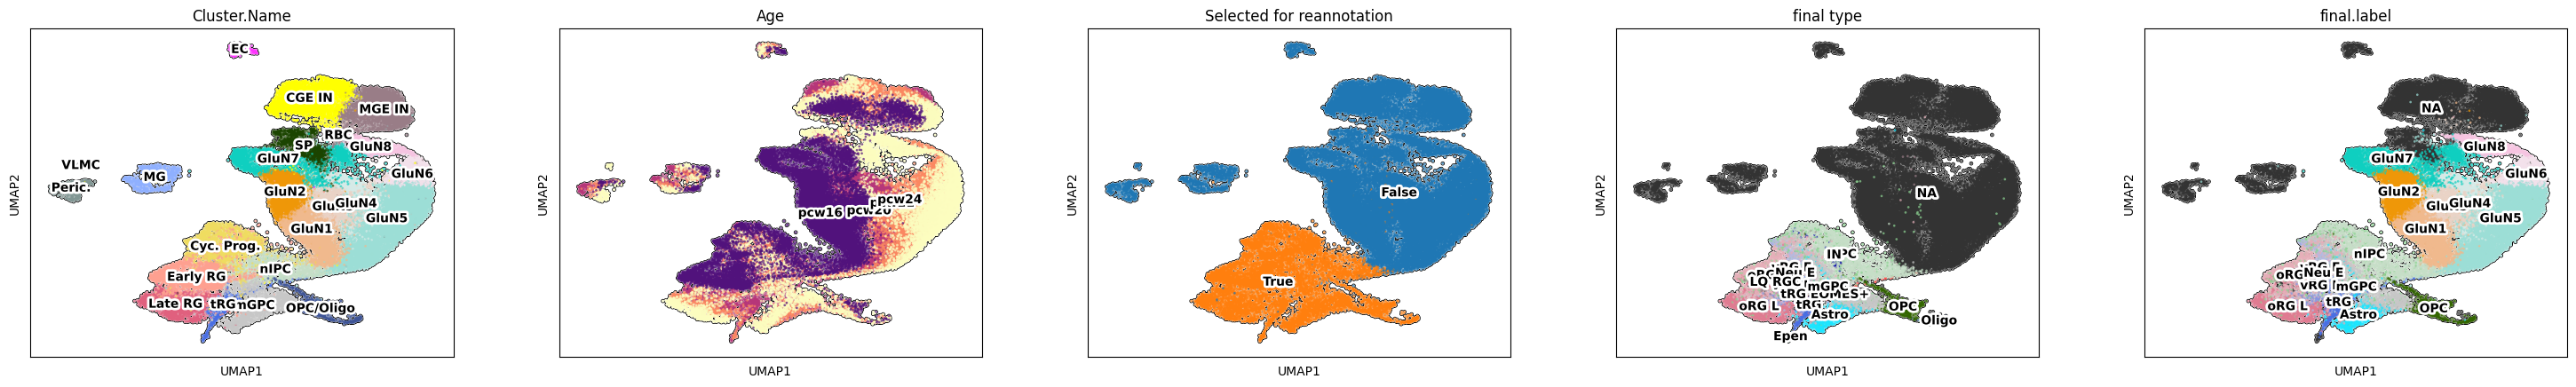

In [51]:

ax = sc.pl.umap(adata, color=['Cluster.Name', 'Age', 'Selected for reannotation', 'final type', 'final.label'],
           # basis='original',
           legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=5,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
plt.savefig('./figures/umap_full_clusters_reannot.on_data.pdf')

# ax = sc.pl.umap(adata, color=['Cluster.Name', 'Age', 'Selected for reannotation', 'final type', 'final.label'], 
#            # basis='original',
#            # legend_loc='on data', 
#            legend_fontoutline=4,
#            na_color='#333333DD',
#            wspace=0.3,
#            show=False,
#            alpha=0.7,
#            ncols=5,
#            # save='_full_clusters_reannot.png',
#            # ax=ax,
#            add_outline=True, size=15)
# for a in ax: a.legend(ncol=1, bbox_to_anchor=(1.04,1))
plt.savefig('./figures/umap_full_clusters_reannot.pdf')


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided

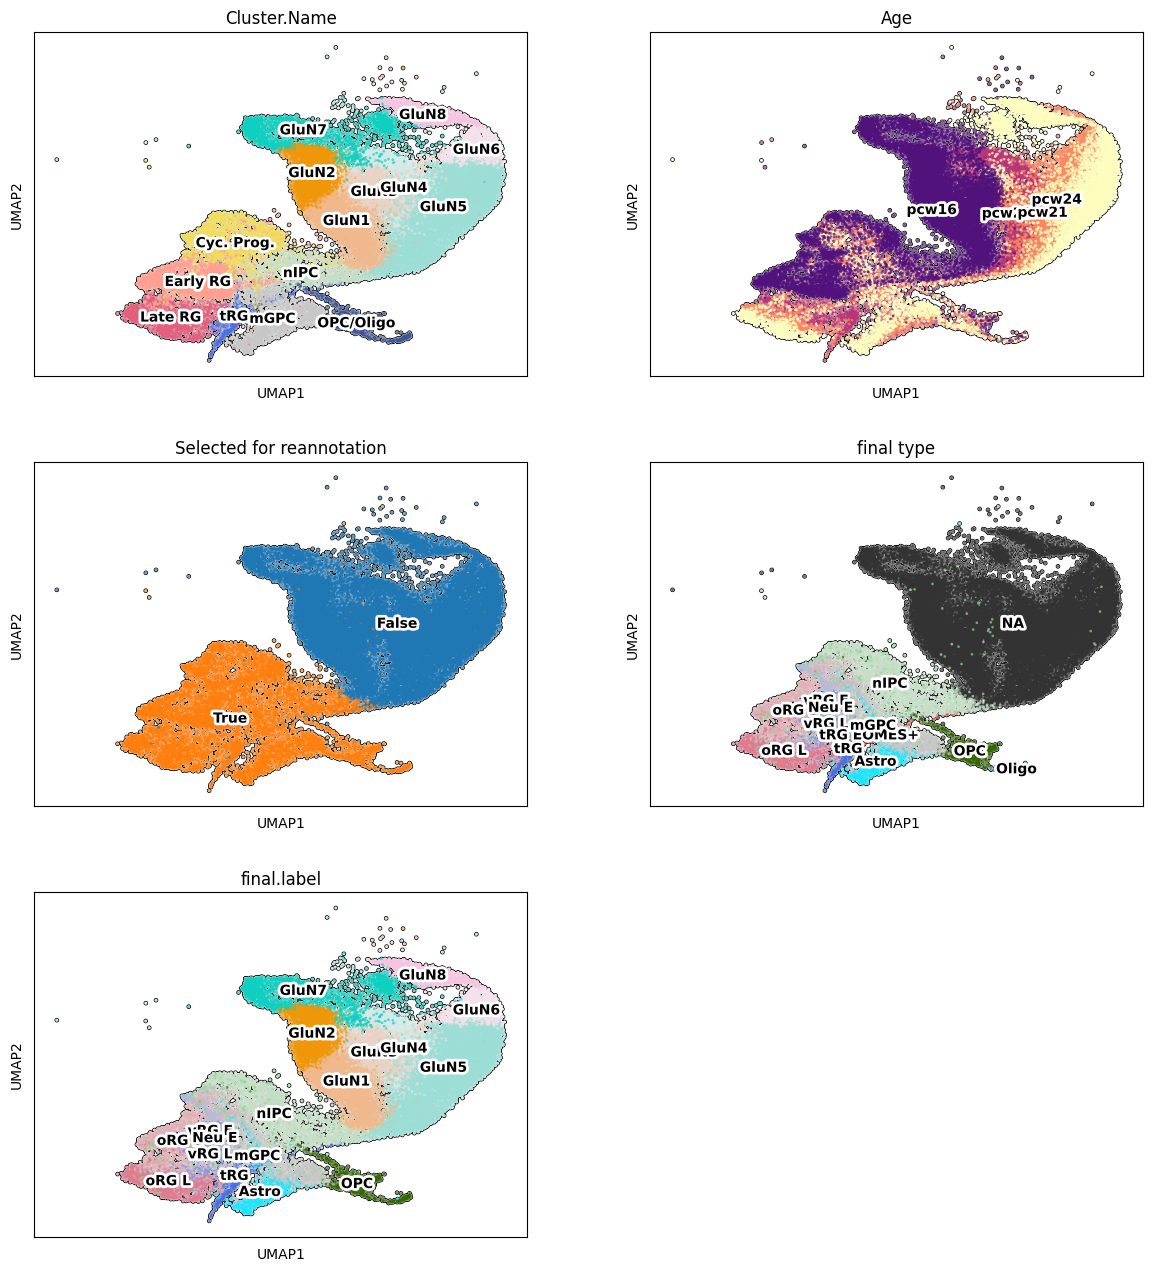

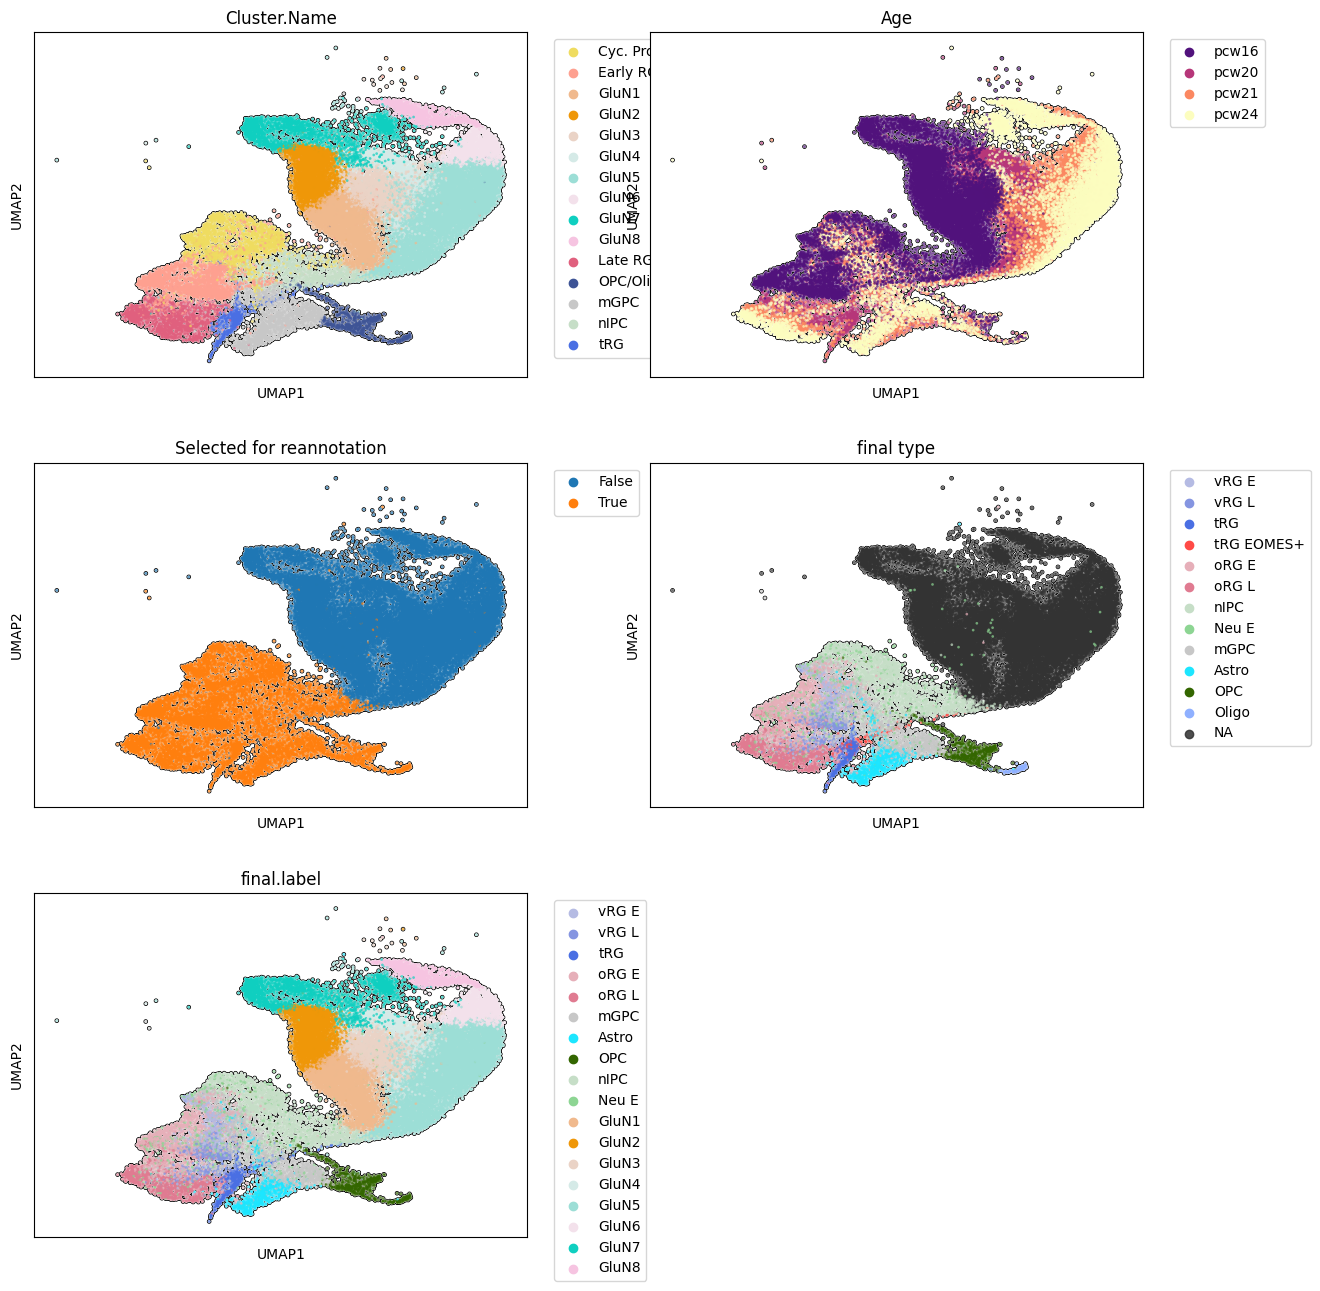

In [34]:

ax = sc.pl.umap(adata[~adata.obs['final.label'].isna(),:], 
           color=['Cluster.Name', 'Age', 'Selected for reannotation', 'final type', 'final.label'],
           # basis='original',
           legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=5,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
plt.savefig('./figures/umap_instudy_clusters_reannot.on_data.pdf')

# ax = sc.pl.umap(adata[~adata.obs['final.label'].isna(),:], 
#            color=['Cluster.Name', 'Age', 'Selected for reannotation', 'final type', 'final.label'], 
#            # basis='original',
#            # legend_loc='on data', 
#            legend_fontoutline=4,
#            wspace=0.5,
#            na_color='#333333DD',
#            show=False,
#            alpha=0.7,
#            ncols=5,
#            # save='_full_clusters_reannot.png',
#            # ax=ax,
#            add_outline=True, size=15)
# for a in ax: a.legend(ncol=1, bbox_to_anchor=(1.04,1))
plt.savefig('./figures/umap_instudy_clusters_reannot.pdf')


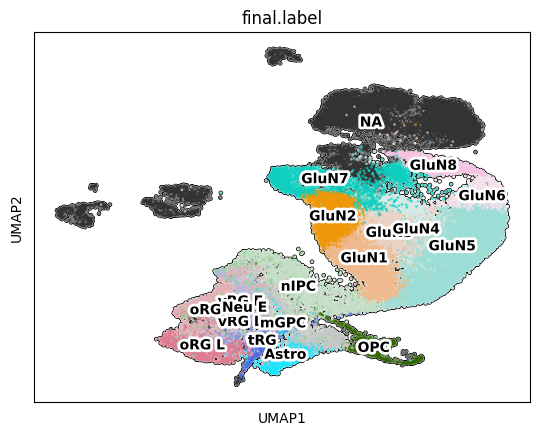

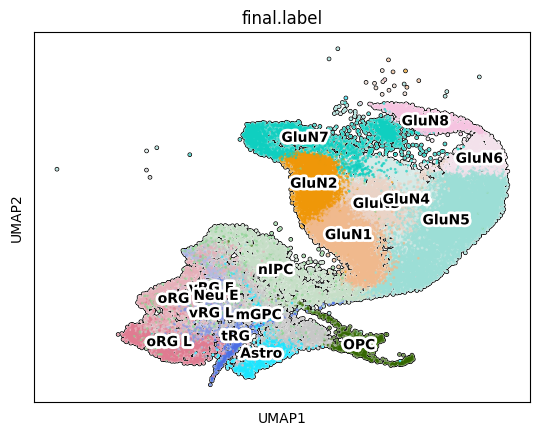

In [38]:
ax = sc.pl.umap(adata, 
           color='final.label',
           # basis='original',
           legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=1,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
plt.show()
ax = sc.pl.umap(adata[~adata.obs['final.label'].isna(),:], 
           color='final.label',
           # basis='original',
           legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=1,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
plt.show()


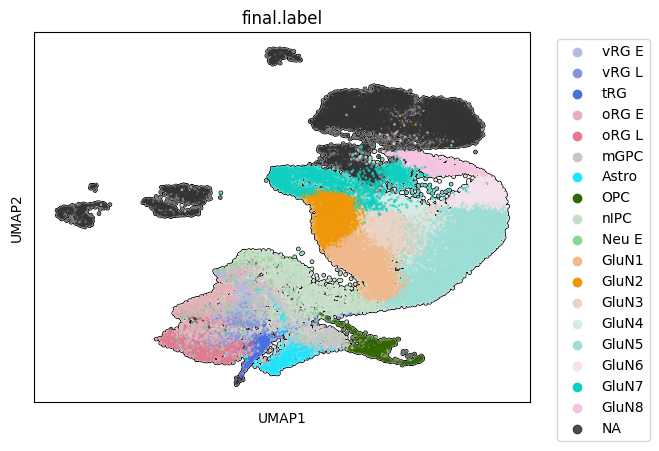

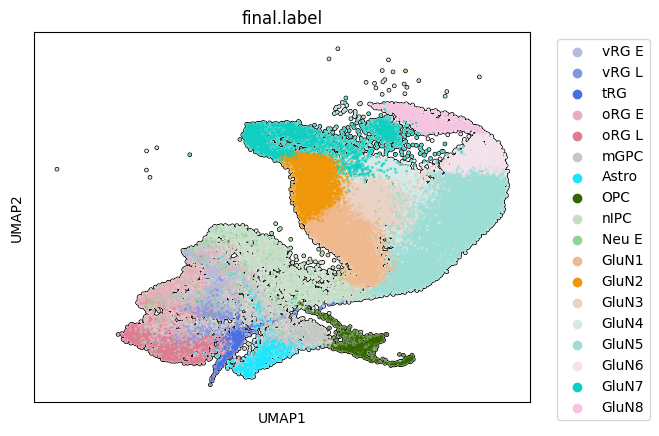

In [41]:
ax = sc.pl.umap(adata, 
           color='final.label',
           # basis='original',
           # legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=1,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
ax.legend(ncol=1, bbox_to_anchor=(1.04,1))
plt.show()
# used in study
ax = sc.pl.umap(adata[~adata.obs['final.label'].isna(),:], 
           color='final.label',
           # basis='original',
           # legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=1,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
ax.legend(ncol=1, bbox_to_anchor=(1.04,1))
plt.show()

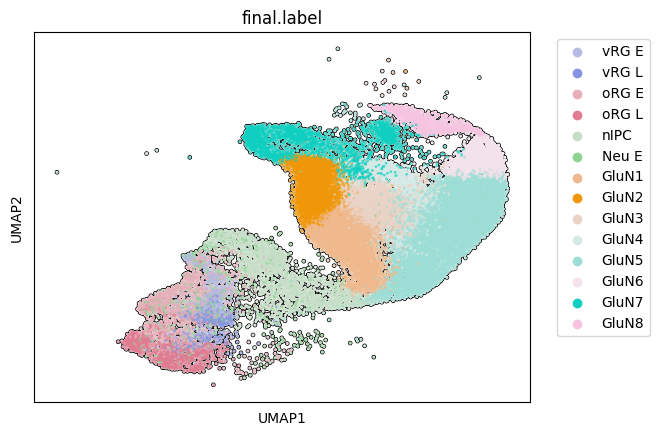

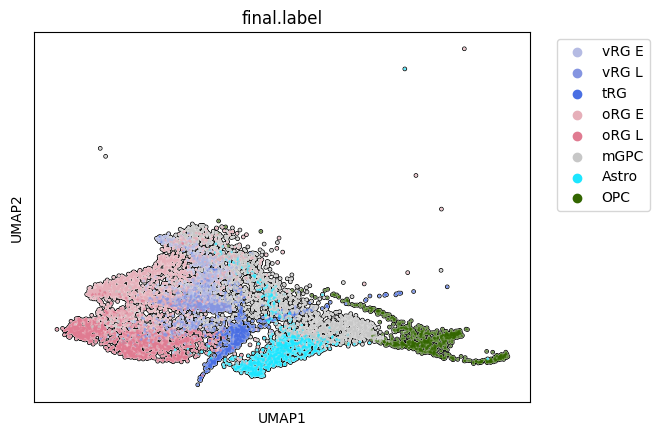

In [46]:
# used in neurogenesis
ax = sc.pl.umap(adata[~adata.obs['final.label'].isna() & ~adata.obs['final.label'].isin(['tRG', 'Astro', 'OPC', 'mGPC']),:], 
           color='final.label',
           # basis='original',
           # legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=1,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
ax.legend(ncol=1, bbox_to_anchor=(1.04,1))
plt.show()
# used in gliogenesis
ax = sc.pl.umap(adata[~adata.obs['final.label'].isna() & ~adata.obs['final.label'].astype(str).str.contains('GluN') & ~adata.obs['final.label'].isin(['nIPC', 'Neu E']),:], 
           color='final.label',
           # basis='original',
           # legend_loc='on data', 
           legend_fontoutline=4,
           na_color='#333333DD',
           show=False,
           alpha=0.7,
           ncols=1,
           # save='_full_clusters_reannot.on_data.png',
           add_outline=True, size=15,
          )
ax.legend(ncol=1, bbox_to_anchor=(1.04,1))
plt.show()

In [77]:
plot_adata = adata[~adata.obs['final.label'].isna(),:]

plot_adata.obs['gliogenesis'] = ~adata.obs['final.label'].isna() & ~adata.obs['final.label'].astype(str).str.contains('GluN') & ~adata.obs['final.label'].isin(['nIPC', 'Neu E'])

plot_adata.obs['neurogenesis']= ~adata.obs['final.label'].isna() & ~adata.obs['final.label'].isin(['tRG', 'Astro', 'OPC', 'mGPC']) 
print(plot_adata.shape)
plot_adata = plot_adata[~((plot_adata.obs['Age'] == 'pcw16') & plot_adata.obs['neurogenesis'] & ~(plot_adata.obs['gliogenesis'])),:]
print(plot_adata.shape)


/tmp/ipykernel_3465062/1980366399.py:3: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  plot_adata.obs['gliogenesis'] = ~adata.obs['final.label'].isna() & ~adata.obs['final.label'].astype(str).str.contains('GluN') & ~adata.obs['final.label'].isin(['nIPC', 'Neu E'])


(44100, 21720)
(30575, 21720)


In [78]:
include_ = {
    'gliogenesis': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'tRG', 
                    'mGPC', 'Astro', 'OPC'],
    'neurogenesis': {
        'pcw16':['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 
                 'nIPC', 'GluN1', 'GluN2', 'GluN3', 'GluN7'],
        'pcw20':['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 
                 'nIPC', 'GluN4', 'GluN5'],    
        'pcw21':['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 
                 'nIPC', 'GluN5', 'GluN6'],        
        'pcw24':['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 
                 'nIPC', 'GluN5', 'GluN6', 'GluN8']
    }   
}

In [90]:
labels = []
palettes = []

for s in ['gliogenesis', 'neurogenesis']:
    
    donors = plot_adata.obs['Age'].unique() if s == 'neurogenesis' else [None]
    
    for d in sorted(donors):
            
        if d == 'pcw16': continue
        if not d:
            
            plabs = np.where(plot_adata.obs['final.label'].isin(include_[s]),
                             plot_adata.obs['final.label'], np.nan)
            label = f'Gliogenesis (all donors)'
        else: 
            plabs = np.where(plot_adata.obs['final.label'].isin(include_[s][d]) & (plot_adata.obs['Age'] == d),
                             plot_adata.obs['final.label'], np.nan)
            label = f'Neurogenesis ({d})'
        
        cats = [c for c in plot_adata.obs['final.label'].cat.categories if c in plabs]
        plot_adata.obs[label] = pd.Categorical(plabs, cats)
        labels.append(label)
        palettes.append({k: v for k,v in final_type_palette.items() if k in cats})

In [91]:
labels

['Gliogenesis (all donors)',
 'Neurogenesis (pcw20)',
 'Neurogenesis (pcw21)',
 'Neurogenesis (pcw24)']

In [98]:
plot_adata = plot_adata[~plot_adata.obs.loc[:,labels].isna().all(1),:]

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


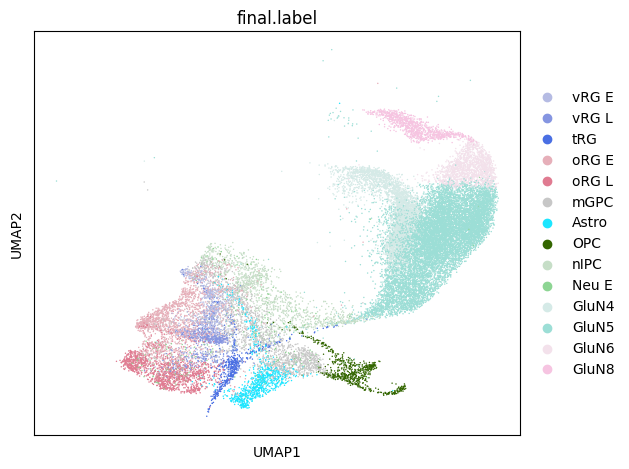

In [108]:
sc.pl.umap(plot_adata, color = 'final.label', show=False)
plt.tight_layout()
plt.savefig('./figures/umap_instudy.for_legend.pdf')

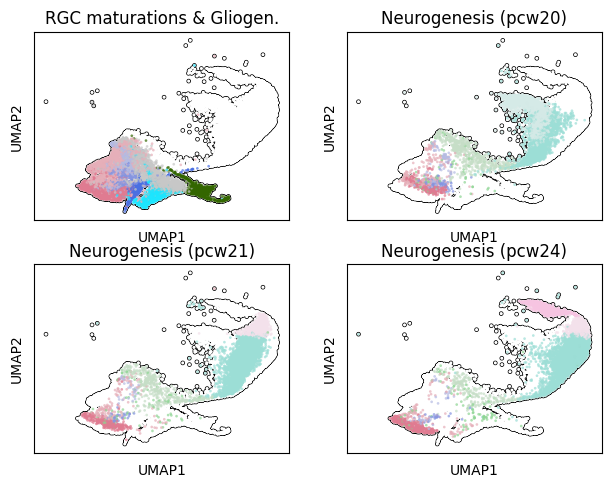

In [100]:
fig, axs = plt.subplots(2,2)
axs = axs.flatten()
fig.tight_layout() # Or equivalently,  "plt.tight_layout()"

i = 0

for lab, pal in zip(labels, palettes):
    sc.pl.umap(
        plot_adata, color = lab,
        legend_loc='none',
        palette=pal,
        # legend_fontoutline=4,
        na_color='#FFFFFF00',
        show=False,
        alpha=0.7,
        ncols=1,
        ax=axs[i],
        # save='_full_clusters_reannot.on_data.png',
        add_outline=True, 
        size=15)
    if i==0:
        axs[i].set_title('RGC maturations & Gliogen.')
    i+=1
        

plt.savefig(f'./figures/umap_instudy.pdf')

---

In [1]:
import scanpy as sc

import os
os.getcwd()

'/users/genomics/xoel/codebases/co_new/src'

In [2]:
adata = sc.read_h5ad('../data/Trevino.RNA.reannotated.h5ad', backed=False)

In [4]:
adata

AnnData object with n_obs × n_vars = 57868 × 21720
    obs: 'Cell.ID', 'Sample.ID', 'Age', 'Tissue.ID', 'Sample.Type', 'Assay', 'Batch', 'seurat_clusters', 'RNA.Counts', 'RNA.Features', 'Percent.MT', 'Percent.Ribo', 'Cell.Barcode', 'DF_pANN', 'DF_classification', 'DF_pANN_quantile', 'Spliced.Counts', 'Spliced.Features', 'Unspliced.Counts', 'Unspliced.Features', 'Ambiguous.Counts', 'Ambiguous.Features', 'Cluster.ID', 'Cluster.Name', 'Cluster.LongName', 'Cluster.In.GluN.trajectory', 'Cluster.Color', 'Cluster.Order', 'Cluster.N_cells', 'cell.type', 'UMAP_0', 'UMAP_1', 'velocity_pseudotime', 'initial_size_unspliced', 'initial_size_spliced', 'initial_size', 'n_counts', 'velocity_self_transition', 'CellType', 'Lineage', 'root_cells', 'end_points', 'nesc_id', 'nesc_id.is_rgc', 'rgcs_id', 'rgcs_id.is_rgc', 'new.annot', 'annot.qc.pass', 'log10.RNA.Counts', 'S_score', 'G2M_score', 'phase', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50

In [46]:
# Slim version
import pandas as pd
slim_dir = '/scratch/TrevinoSlim'
os.makedirs(slim_dir, exist_ok=True)

# Extracting all tables at once makes sure we have the right indexing in all of them
# 1. count table
tbl_counts = adata.to_df()

# 2. obs table
tbl_obs = adata.obs.copy()
# 3. var table
tbl_var = adata.var.copy()
# 4. SCVI embedding
tbl_SCVI = adata.obsm['X_scvi']
tbl_SCVI = pd.DataFrame(tbl_SCVI, columns=[f'SCVI {i}' for i in range(tbl_SCVI.shape[1])], index=adata.obs_names)
# 5. Original UMAP
tbl_UMAP = adata.obsm['X_umap_original']
tbl_UMAP = pd.DataFrame(tbl_UMAP, columns=[f'UMAP {i}' for i in range(tbl_UMAP.shape[1])], index=adata.obs_names)
# 6. Color palette
tbl_colors = pd.DataFrame({'hex': adata.uns['final.label_colors'], 'final.label': adata.obs['final.label'].cat.categories})

# save tables
tbl_counts.to_csv(f'{slim_dir}/counts.tsv', sep='\t', index=True, header=True)
tbl_obs.to_csv(f'{slim_dir}/meta_cells.tsv', sep='\t', index=True, header=True)
tbl_var.to_csv(f'{slim_dir}/meta_genes.tsv', sep='\t', index=True, header=True)
tbl_SCVI.to_csv(f'{slim_dir}/embedding_SCVI.tsv', sep='\t', index=True, header=True)
tbl_UMAP.to_csv(f'{slim_dir}/embedding_UMAP.tsv', sep='\t', index=True, header=True)
tbl_colors.to_csv(f'{slim_dir}/final.label_colors.tsv', sep='\t', index=True, header=True)


# create an adata slim
adata_slim = adata.copy()
del adata_slim.obsm['X_umap_original']
del adata_slim.obsm['X_scvi']
del adata_slim.layers['scvi_normalized']

# save adata
adata_slim.write_h5ad(f'{slim_dir}scrna_trevino_slim.h5ad')

In [57]:
slim_dir = '/scratch/TrevinoSlim'
slim_destdir = '/projects_ng/SC_DATA/Trevino/reannotated'
os.makedirs('/projects_ng/SC_DATA/Trevino', exist_ok=True)

# move to final destination:
!scp -rv {slim_dir} shiva:{slim_destdir}

In [3]:
for c in adata.obs.columns:
    adata.obs[c] = adata.obs[c].tolist()

In [33]:
import pandas as pd
pd.DataFrame(adata.obsm['X_umap']).to_csv('../data/adata.umap.csv', index=False)

In [25]:
adata.obs.to_csv('./../data/adata.obs.csv', index=True)
adata.var.to_csv('./../data/adata.var.csv', index=True)

In [23]:
adata.X = a

In [32]:
adata.write_h5ad('../data/Trevino.RNA.reannotated.slim.h5ad')

TypeError: write_h5ad() got an unexpected keyword argument 'index'

# **RNA //** Subsets

Using the reannotated data, we selected RGCs (early and late; ventricular, truncated and outer), as well as mGPCs, astrocytes and OPCs to obtain a representative dataset of the gliogenic differentiation and maturation of RGCs.  
To analyse the neurogenesis trajectories, we took RGCs (except for tRGs), nIPCs, early neurons and glutamatergic neurons, in each donor separately.  
In this way, we obtained four data subsets of neurogenesis at 16, 20, 21 and 24 post-conceptional weeks of age and one subset of RGC maturation and gliogenesis across all periods.

In [ ]:
subsets = {
    'NeuralPCW16': { 
        'Age': 'pcw16',
        'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN1', 'GluN2', 'GluN3', 'GluN7']        
    },
    'NeuralPCW20': {
        'Age': 'pcw20',
        'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN4', 'GluN5']        
    },
    'NeuralPCW21': {
        'Age': 'pcw21',
        'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN5', 'GluN6']        
    },
    'NeuralPCW24': {
        'Age': 'pcw24',
        'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN5', 'GluN6', 'GluN8']        
    },
    'Gliogenesis': {
        'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'tRG', 'mGPC', 'Astro', 'OPC']
    }
    # 'GliogenesisExtended': {
    #     'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'tRG', 'mGPC', 'Astro', 'OPC']
    # },
    # 'RGCmaturation': {
    #     'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'tRG']
    # },
    # 'RGCmaturationExtended': {
    #     'final type': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'tRG']
    # }
}

  0%|          | 0/5 [00:00<?, ?it/s]

NeuralPCW16
{'Age': 'pcw16', 'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN1', 'GluN2', 'GluN3', 'GluN7']}


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(15720, 21720)
NeuralPCW20
{'Age': 'pcw20', 'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN4', 'GluN5']}


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(7437, 21720)
NeuralPCW21
{'Age': 'pcw21', 'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN5', 'GluN6']}


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(6455, 21720)
NeuralPCW24
{'Age': 'pcw24', 'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'Neu E', 'nIPC', 'GluN5', 'GluN6', 'GluN8']}


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(7709, 21720)
Gliogenesis
{'final.label': ['vRG E', 'vRG L', 'oRG E', 'oRG L', 'tRG', 'mGPC', 'Astro', 'OPC']}


/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/anndata/compat/_overloaded_dict.py:106: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  self.data[key] = value
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


(8513, 21720)


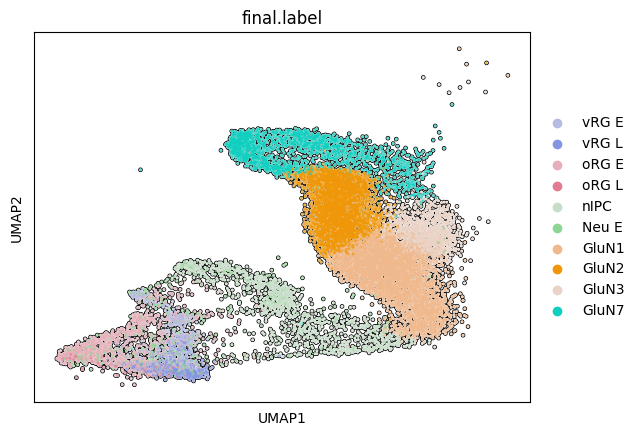

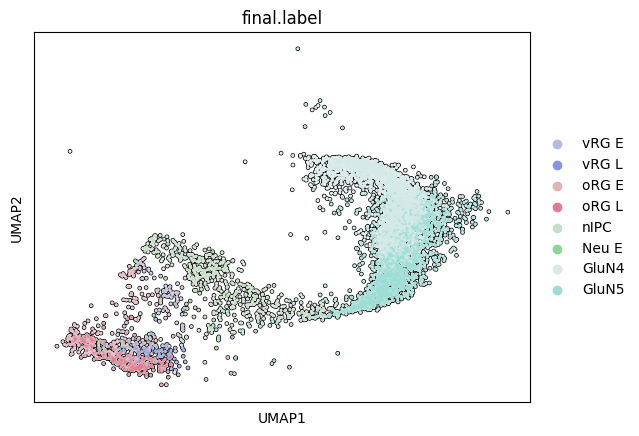

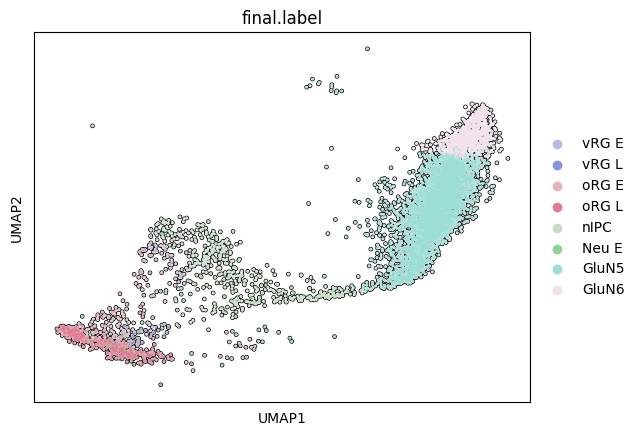

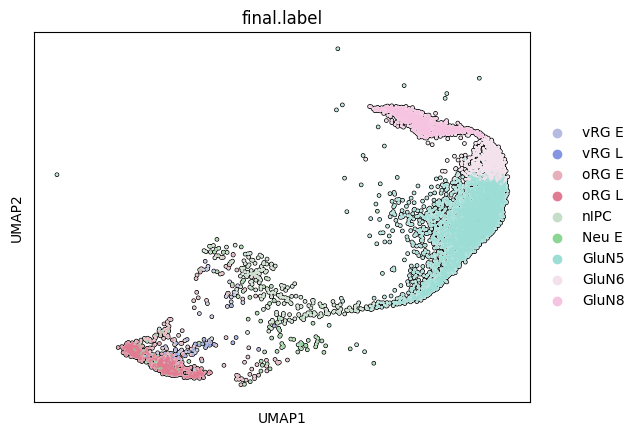

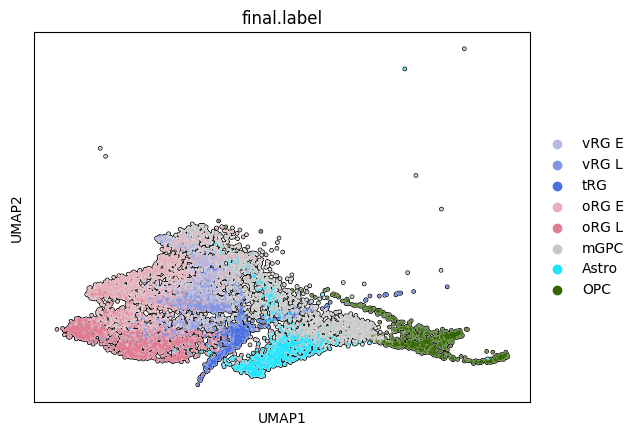

In [77]:
for filt_name, filts in tqdm(subsets.items()):
    print(filt_name)
    print(filts)
    
    filt_adata = adata.copy()
    for filt_col, filt_values in filts.items():

        if isinstance(filt_values, str):
            filt_adata = filt_adata[filt_adata.obs.loc[:,filt_col] == filt_values]
            if not filt_values in filt_adata.obs[filt_col].unique():
                raise
        else:
            filt_adata = filt_adata[filt_adata.obs[filt_col].isin(filt_values)]
            if not np.isin(filt_values, filt_adata.obs[filt_col].unique()).all():
                print(f'''\
                Requested: {filt_values}
                Pre-filtered: {adata.obs[filt_col].unique().tolist()}
                Filtered: {filt_adata.obs[filt_col].unique().tolist()}''')
                raise
        
    
    # Correct palette before saving
    filt_adata.uns['final.label_colors'] = [palette[k] for k in filt_adata.obs['final.label'].cat.categories]
    filt_adata.uns['Cluster.Name_colors'] = []
    for i, k in enumerate(filt_adata.obs['Cluster.Name'].cat.categories):
        col = clusters_palette[k] if k in clusters_palette.keys() else sc.pl.palettes.godsnot_102[i]
        filt_adata.uns['Cluster.Name_colors'].append(col)
    filt_adata.uns['final type_colors'] = []
    for i, k in enumerate(filt_adata.obs['final type'].cat.categories):
        col = final_type_palette[k] if k in final_type_palette.keys() else sc.pl.palettes.godsnot_102[i]
        filt_adata.uns['final type_colors'].append(col)


    sc.pl.umap(
        filt_adata, color = 'final.label',
        # legend_loc='on data',
        # palette={k: v for k,v in final_type_palette.items() if k in cats},
        # legend_fontoutline=4,
        na_color='white',
        show=False,
        alpha=0.7,
        ncols=1,
        # save='_full_clusters_reannot.on_data.png',
        add_outline=True, size=15)

#     ax = sc.pl.umap(filt_adata, color=['Cluster.Name', 'Age', 'Selected for reannotation', 'final type', 'final.label'],
#                # basis='original',
#                legend_loc='on data', 
#                legend_fontoutline=4,
#                na_color='#333333DD',
#                show=False,
#                alpha=0.7,
#                ncols=2,
#                # save='_full_clusters_reannot.on_data.png',
#                add_outline=True, size=15,
#               )
#     plt.savefig(f'./figures/umap_{filt_name}_clusters_reannot.on_data.pdf')

#     ax = sc.pl.umap(filt_adata, color=['Cluster.Name', 'Age', 'Selected for reannotation', 'final type', 'final.label'], 
#                # basis='original',
#                # legend_loc='on data', 
#                legend_fontoutline=4,
#                na_color='#333333DD',
#                show=False,
#                alpha=0.7,
#                ncols=2,
#                # save='_full_clusters_reannot.png',
#                # ax=ax,
#                add_outline=True, size=15)
#     for a in ax: a.legend(ncol=1, bbox_to_anchor=(1.04,1))
    plt.savefig(f'./figures/umap_{filt_name}_clusters_reannot.pdf')

    
    
    print(filt_adata.shape)

    # os.makedirs(filt_name, exist_ok=True)
    # fname = os.path.join(filt_name, 'RNA.unprocessed.h5ad')
    # print(fname)
    # filt_adata.write_h5ad(fname)

    

### Full subset but downsampled

In [88]:
min_ct_count = adata.obs['final.label'].value_counts().min()
min_ct_count

573

In [120]:
adata_subsampled = sc.concat([sc.pp.subsample(adata[adata.obs['final.label']==c,:], n_obs=min_ct_count, copy=True) for c in adata.obs['final.label'].cat.categories if c in palette.keys()])

In [125]:
adata.obs['final.label']

hft_w20_p3_r1_AAACCCAAGCTGCGAA      NaN
hft_w20_p3_r1_AAACCCAAGGTAGTAT    Astro
hft_w20_p3_r1_AAACCCACAACTCCAA      OPC
hft_w20_p3_r1_AAACCCACATAGTCAC    GluN5
hft_w20_p3_r1_AAACCCAGTACAGGTG    GluN4
                                  ...  
hft_w16_p7_r2_TTTGTTGCAGCACCCA     mGPC
hft_w16_p7_r2_TTTGTTGCAGGCTACC    GluN1
hft_w16_p7_r2_TTTGTTGGTCGCTTAA    GluN1
hft_w16_p7_r2_TTTGTTGGTCGTACAT    GluN1
hft_w16_p7_r2_TTTGTTGGTTAGTTCG    oRG E
Name: final.label, Length: 57868, dtype: category
Categories (18, object): ['vRG E', 'vRG L', 'tRG', 'oRG E', ..., 'GluN5', 'GluN6', 'GluN7', 'GluN8']

In [127]:
adata_subsampled.obs['final.label'] = pd.Categorical(adata_subsampled.obs['final.label'], categories=adata.obs['final.label'].cat.categories)

/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:369: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:379: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  ax.scatter(
/users/genomics/xoel/venvs/co_0.12/lib/python3.8/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


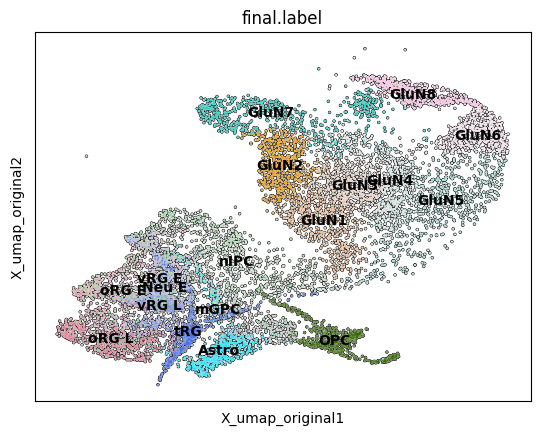

In [128]:
adata_subsampled.uns['final.label_colors'] = [palette[k] for k in adata_subsampled.obs['final.label'].cat.categories]
sc.pl.embedding(adata_subsampled, basis='X_umap_original', color='final.label',
                add_outline=True, size=8, legend_loc='on data')

In [129]:
os.makedirs('Downsampled', exist_ok=True)
fname = os.path.join('Downsampled', 'RNA.unprocessed.h5ad')
print(fname)
adata_subsampled.write_h5ad(fname)

Downsampled/RNA.unprocessed.h5ad


# **RNA //** cell counts

In [ ]:
import seaborn as sns

In [28]:
counts = pd.crosstab(cell_metadata['Age'],cell_metadata['Cluster.Name'])
counts = counts[sorted(counts.columns)] 

In [29]:
counts.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True))

In [30]:
freq_ct = counts.div(counts.sum(0))
freq_ct.style.background_gradient(cmap=sns.light_palette("purple", as_cmap=True))

In [31]:
freq_age = counts.div(counts.sum(1), axis='rows')
freq_age.style.background_gradient(cmap=sns.light_palette("darkblue", as_cmap=True))

In [32]:
counts_cts = pd.crosstab(cell_metadata['new.annot'],cell_metadata['Cluster.Name'])
counts_cts = counts_cts[sorted(counts_cts.columns)] 

In [33]:
counts_cts.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True))

In [34]:
freq_ct_ori = counts_cts.div(counts_cts.sum(0))
freq_ct_ori.style.background_gradient(cmap=sns.light_palette("purple", as_cmap=True))

In [35]:
freq_ct_new = counts_cts.div(counts_cts.sum(1), axis='rows')
(freq_ct_new * 100).style.background_gradient(cmap=sns.light_palette("darkblue", as_cmap=True))

In [36]:
counts_fin = pd.crosstab(cell_metadata['Age'],cell_metadata['rgcs_id'])
counts_fin = counts_fin[sorted(counts_fin.columns)] 

In [37]:
counts_fin.style.background_gradient(cmap=sns.light_palette("green", as_cmap=True))

In [38]:
freq_ct_fin = counts_fin.div(counts_fin.sum(0))
freq_ct_fin.style.background_gradient(cmap=sns.light_palette("purple", as_cmap=True))

In [39]:
freq_ct_age = counts_fin.div(counts_fin.sum(1), axis='rows')
freq_ct_age.style.background_gradient(cmap=sns.light_palette("darkblue", as_cmap=True))

In [40]:
print('hello')

hello


In [41]:
nesc_new_annot = [
                  'vRG E', 'vRG L', 'tRG', 'oRG E', 'oRG L', 'mGPC', 'Astro', 'OPC', 'Oligo'
                 ]
cell_metadata['is_nep'] = cell_metadata['new.annot'].isin(nesc_new_annot)

In [43]:
# cell_metadata.groupby('Age').value_counts(['rgcs_id.is_rgc']).unstack()

# cell_metadata.groupby('Age').value_counts(['rgcs_id.is_rgc']).unstack().iloc[:,[1]].join(
#     cell_metadata.groupby('Age').value_counts(['is_nep']).unstack().iloc[:,[1]],
#     lsuffix=' RGC', rsuffix=' NEP'
# ).plot.bar()

# cell_metadata.columns

# cell_metadata.groupby('new.annot').value_counts(['Age']).unstack().plot.bar(stacked=True)

# cell_metadata.groupby('Cluster.Name').value_counts(['Age']).unstack().plot.bar(stacked=True)

# cell_metadata.groupby('Age').value_counts(['rgcs_id.is_rgc']).unstack().iloc[:,[1]].join(
#     cell_metadata.groupby('Age').value_counts(['is_nep']).unstack().iloc[:,[1]],
#     lsuffix=' RGC', rsuffix=' NEP'
# ).plot.bar()

---

# **ATAC //** Cell metadata

In [92]:
atac_cl_cts = {
    'c0':'GluN6',
    'c1':'GluN4',
    'c2':'GluN7',
    'c3':'IN2', 
    'c4':'IN4', 
    'c5':'GluN9', 
    'c6':'GluN2', 
    'c7':'GluN3', 
    'c8':'nIPC', 
    'c9':'Late RG',
    'c10':'oIPC',
    'c11':'Early RG', 
    'c12':'IN3', 
    'c13':'GluN5', 
    'c14':'GluN8',
    'c15':'OPC/Oligo', 
    'c16':'IN5', 
    'c17':'Peric.',
    'c18':'GluN1',
    'c19':'MG',
    'c20':'IN1',
    'c21':'EC'
}

sorted(atac_cl_cts.values())

['EC',
 'Early RG',
 'GluN1',
 'GluN2',
 'GluN3',
 'GluN4',
 'GluN5',
 'GluN6',
 'GluN7',
 'GluN8',
 'GluN9',
 'IN1',
 'IN2',
 'IN3',
 'IN4',
 'IN5',
 'Late RG',
 'MG',
 'OPC/Oligo',
 'Peric.',
 'nIPC',
 'oIPC']

In [93]:
cell_metadata = pd.read_csv(f'{trevino_dir}GSE162170_atac_cell_metadata.txt', sep='\t')
cell_metadata.set_index('Cell.ID', drop=False, inplace=True)
cell_metadata['Cluster.Name'] = [atac_cl_cts[cl] for cl in cell_metadata['Iterative.LSI.Clusters']]
cell_metadata['cell.type'] = cell_metadata['Cluster.Name'].str.replace('/', '_', regex=False).str.replace(' ', '_', regex=False)
cell_metadata.head()

Cell.ID      Sample.ID    Age Tissue.ID  \
Cell.ID                                                                      
hft_w20_p3_r1_cell_0  hft_w20_p3_r1_cell_0  hft_w20_p3_r1  pcw20      HFT3   
hft_w20_p3_r1_cell_1  hft_w20_p3_r1_cell_1  hft_w20_p3_r1  pcw20      HFT3   
hft_w20_p3_r1_cell_2  hft_w20_p3_r1_cell_2  hft_w20_p3_r1  pcw20      HFT3   
hft_w20_p3_r1_cell_3  hft_w20_p3_r1_cell_3  hft_w20_p3_r1  pcw20      HFT3   
hft_w20_p3_r1_cell_4  hft_w20_p3_r1_cell_4  hft_w20_p3_r1  pcw20      HFT3   

                     Sample.Type     Batch Iterative.LSI.Clusters  \
Cell.ID                                                             
hft_w20_p3_r1_cell_0         HFT  b2019_06                     c7   
hft_w20_p3_r1_cell_1         HFT  b2019_06                     c4   
hft_w20_p3_r1_cell_2         HFT  b2019_06                    c13   
hft_w20_p3_r1_cell_3         HFT  b2019_06                     c7   
hft_w20_p3_r1_cell_4         HFT  b2019_06                     c1   

                      Tss.Enrichment  .CR.cellQC.barcode  .CR.cellQC.total  \
Cell.ID                                                                      
hft_w20_p3_r1_cell_0       21.529711  AAACGAAAGAGCGAAA-1            106900   
hft_w20_p3_r1_cell_1       23.737453  AAACGAAAGCAGGACT-1            120734   
hft_w20_p3_r1_cell_2       28.220040  AAACGAAAGGATCCTT-1            112894   
hft_w20_p3_r1_cell_3       21.165212  AAACGAAAGGCTTCGC-1             94462   
hft_w20_p3_r1_cell_4       30.964802  AAACGAACAAAGCTGG-1             75329   

                      ...  .CR.cellQC.enhancer_region_fragments  \
Cell.ID               ...                                         
hft_w20_p3_r1_cell_0  ...                                  7037   
hft_w20_p3_r1_cell_1  ...                                  6088   
hft_w20_p3_r1_cell_2  ...                                  9120   
hft_w20_p3_r1_cell_3  ...                                  6789   
hft_w20_p3_r1_cell_4  ...                                  7305   

                      .CR.cellQC.promoter_region_fragments  \
Cell.ID                                                      
hft_w20_p3_r1_cell_0                                 16111   
hft_w20_p3_r1_cell_1                                 20757   
hft_w20_p3_r1_cell_2                                 17505   
hft_w20_p3_r1_cell_3                                 15255   
hft_w20_p3_r1_cell_4                                 10044   

                      .CR.cellQC.on_target_fragments  \
Cell.ID                                                
hft_w20_p3_r1_cell_0                           31479   
hft_w20_p3_r1_cell_1                           33613   
hft_w20_p3_r1_cell_2                           36640   
hft_w20_p3_r1_cell_3                           29934   
hft_w20_p3_r1_cell_4                           24259   

                      .CR.cellQC.blacklist_region_fragments  \
Cell.ID                                                       
hft_w20_p3_r1_cell_0                                      0   
hft_w20_p3_r1_cell_1                                      1   
hft_w20_p3_r1_cell_2                                      0   
hft_w20_p3_r1_cell_3                                      2   
hft_w20_p3_r1_cell_4                                      0   

                      .CR.cellQC.peak_region_fragments  \
Cell.ID                                                  
hft_w20_p3_r1_cell_0                             32017   
hft_w20_p3_r1_cell_1                             33311   
hft_w20_p3_r1_cell_2                             37145   
hft_w20_p3_r1_cell_3                             30571   
hft_w20_p3_r1_cell_4                             24423   

                      .CR.cellQC.peak_region_cutsites        Cell.Barcode  \
Cell.ID                                                                     
hft_w20_p3_r1_cell_0                            62530  AAACGAAAGAGCGAAA-1   
hft_w20_p3_r1_cell_1                            65168  AAACGAAAGCAGGACT-1   
hf

# **ATAC //** Peak metadata

In [94]:
peak_metadata = pd.read_csv(f'{trevino_dir}GSE162170_atac_consensus_peaks.bed', sep='\t', header=None, usecols=[0,1,2])
peak_metadata.columns = ["chr", "bp1", "bp2"]
peak_metadata['site_name'] = peak_metadata.astype(str).apply(lambda x: '_'.join(x), axis=1)
peak_metadata.set_index('site_name', drop=False, inplace=True)
peak_metadata.head()

chr     bp1     bp2           site_name
site_name                                                   
chr1_10027_10528    chr1   10027   10528    chr1_10027_10528
chr1_180646_181147  chr1  180646  181147  chr1_180646_181147
chr1_181233_181734  chr1  181233  181734  chr1_181233_181734
chr1_191217_191718  chr1  191217  191718  chr1_191217_191718
chr1_265925_266426  chr1  265925  266426  chr1_265925_266426

# **ATAC //** Export metadata

In [95]:
cell_metadata.to_csv('Trevino.ATAC.cell_metadata.csv')

In [96]:
peak_metadata.to_csv('Trevino.ATAC.peak_metadata.csv')

# **ATAC //** Subsets

In [97]:
subsets = {
    'NeuralPCW16': {
        'Age': 'pcw16',
        'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN1', 'GluN2', 'GluN3', 'GluN8']        
    },
    'NeuralPCW20': {
        'Age': 'pcw20',
        'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN3', 'GluN4', 'GluN5']        
    },
    'NeuralPCW21': {
        'Age': 'pcw21',
        'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN4', 'GluN6', 'GluN7', 'GluN9']        
    },
    'NeuralPCW24': {
        'Age': 'pcw24',
        'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN4', 'GluN6', 'GluN7', 'GluN9']        
    },
    'Gliogenesis': {
        'cell.type': ['Early_RG', 'Late_RG', 'oIPC', 'OPC_Oligo']
    },
    'GliogenesisExtended': {
        'cell.type': ['Early_RG', 'Late_RG', 'oIPC', 'OPC_Oligo']
    },
    'RGCmaturation': {
        'cell.type': ['Early_RG', 'Late_RG']
    },
    'RGCmaturationExtended': {
        'cell.type': ['Early_RG', 'Late_RG']
    }
}

In [114]:
atac_cts = list({v for k in subsets.values() for v in k['cell.type']})

atac_min_cells = min([
    v for k,v in cell_metadata.groupby('cell.type')['Cell.ID'].size().to_dict().items() if k in atac_cts
])

subsets['Downsampled'] = {
    'Cell.ID': cell_metadata[cell_metadata['cell.type'].isin(atac_cts)].groupby('cell.type').sample(atac_min_cells)['Cell.ID'].tolist()}
subsets

{'NeuralPCW16': {'Age': 'pcw16',
  'cell.type': ['Early_RG',
   'Late_RG',
   'nIPC',
   'GluN1',
   'GluN2',
   'GluN3',
   'GluN8']},
 'NeuralPCW20': {'Age': 'pcw20',
  'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN3', 'GluN4', 'GluN5']},
 'NeuralPCW21': {'Age': 'pcw21',
  'cell.type': ['Early_RG',
   'Late_RG',
   'nIPC',
   'GluN4',
   'GluN6',
   'GluN7',
   'GluN9']},
 'NeuralPCW24': {'Age': 'pcw24',
  'cell.type': ['Early_RG',
   'Late_RG',
   'nIPC',
   'GluN4',
   'GluN6',
   'GluN7',
   'GluN9']},
 'Gliogenesis': {'cell.type': ['Early_RG', 'Late_RG', 'oIPC', 'OPC_Oligo']},
 'GliogenesisExtended': {'cell.type': ['Early_RG',
   'Late_RG',
   'oIPC',
   'OPC_Oligo']},
 'RGCmaturation': {'cell.type': ['Early_RG', 'Late_RG']},
 'RGCmaturationExtended': {'cell.type': ['Early_RG', 'Late_RG']},
 'Downsampled': {'Cell.ID': ['hft_w16_p7_r3_cell_2527',
   'hft_w16_p7_r2_cell_219',
   'hft_w16_p7_r2_cell_388',
   'hft_w20_p3_r1_cell_2082',
   'hft_w16_p7_r3_cell_1305',
   'hft_w16_p7

In [115]:
subset_cells = []
for filt_name, filts in subsets.items():
    print(filt_name)
    print(filts)
    
    filt_meta = cell_metadata
    for filt_col, filt_values in filts.items():

        if isinstance(filt_values, str):
            filt_meta = filt_meta[filt_meta[filt_col] == filt_values]
            if not filt_values in filt_meta[filt_col].unique():
                raise
        else:
            filt_meta = filt_meta[filt_meta[filt_col].isin(filt_values)]
            if not np.isin(filt_values, filt_meta[filt_col].unique()).all():
                raise
    
    print(filt_meta.shape)
    subset_cells.append({'subset_name': filt_name,
                         'cell_cols': np.where(cell_metadata.index.isin(filt_meta.index))[0]})

NeuralPCW16
{'Age': 'pcw16', 'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN1', 'GluN2', 'GluN3', 'GluN8']}
(5343, 30)
NeuralPCW20
{'Age': 'pcw20', 'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN3', 'GluN4', 'GluN5']}
(2986, 30)
NeuralPCW21
{'Age': 'pcw21', 'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN4', 'GluN6', 'GluN7', 'GluN9']}
(7964, 30)
NeuralPCW24
{'Age': 'pcw24', 'cell.type': ['Early_RG', 'Late_RG', 'nIPC', 'GluN4', 'GluN6', 'GluN7', 'GluN9']}
(5301, 30)
Gliogenesis
{'cell.type': ['Early_RG', 'Late_RG', 'oIPC', 'OPC_Oligo']}
(4435, 30)
GliogenesisExtended
{'cell.type': ['Early_RG', 'Late_RG', 'oIPC', 'OPC_Oligo']}
(4435, 30)
RGCmaturation
{'cell.type': ['Early_RG', 'Late_RG']}
(2865, 30)
RGCmaturationExtended
{'cell.type': ['Early_RG', 'Late_RG']}
(2865, 30)
Downsampled
{'Cell.ID': ['hft_w16_p7_r3_cell_2527', 'hft_w16_p7_r2_cell_219', 'hft_w16_p7_r2_cell_388', 'hft_w20_p3_r1_cell_2082', 'hft_w16_p7_r3_cell_1305', 'hft_w16_p7_r3_cell_745', 'hft_w20_p3_r2_cell_889', '

In [116]:
def subset_atac(subset_name, cell_cols, atac_counts_tsv, cell_metadata, peak_metadata):
       
    print(f'{subset_name}: Reading ATAC data\n')
    atac_counts = pd.read_csv(atac_counts_tsv, header=None, sep='\t', 
                              usecols=cell_cols)
    atac_counts.columns = cell_metadata['Cell.ID'].iloc[cell_cols].values
    atac_counts.index = peak_metadata['site_name']

    # Optional to do it here, but reduces size
    print(f'{subset_name}: Filtering empty peaks and binarizing\n')
    atac_counts = atac_counts.loc[atac_counts.sum(1) > 0,:]
    atac_counts = (atac_counts > 0).astype(int)

    os.makedirs(subset_name, exist_ok=True)

    fname = os.path.join(subset_name, 'ATAC.unprocessed.tsv')
    print(f'{subset_name}: Saving {fname}\n')
    atac_counts.to_csv(fname, header=True, index=True, sep='\t')
    
    cell_fname = os.path.join(subset_name, 'ATAC.cell_metadata.tsv')
    print(f'{subset_name}: Saving {cell_fname}\n')
    cell_metadata.loc[atac_counts.columns,:].to_csv(cell_fname, header=True, index=True, sep='\t')
    
    peaks_fname = os.path.join(subset_name, 'ATAC.peak_metadata.tsv')
    print(f'{subset_name}: Saving {peaks_fname}\n')
    peak_metadata.loc[atac_counts.index,:].to_csv(peaks_fname, header=True, index=False, sep='\t')
    
    print(f'{subset_name}: Done\n\n')
    
def _subset_atac(kwargs):
    subset_atac(**kwargs,
                atac_counts_tsv=f'{trevino_dir}GSE162170_atac_counts.tsv',
                cell_metadata=cell_metadata,
                peak_metadata=peak_metadata)
    return()

In [117]:
# os.chdir('/scratch/xoel/mar-09/')
# for args in tqdm(subset_cells): _subset_atac(args) 

In [118]:
from tqdm.contrib.concurrent import process_map  # or thread_map

process_map(_subset_atac, subset_cells, max_workers=5) # len(subset_cells)) # 3 so it doesn't go over 190GB in RAM

NeuralPCW16: Reading ATAC data
NeuralPCW20: Reading ATAC data


  0%|          | 0/9 [00:00<?, ?it/s]

NeuralPCW21: Reading ATAC data
NeuralPCW24: Reading ATAC data
Gliogenesis: Reading ATAC data





NeuralPCW20: Filtering empty peaks and binarizing

NeuralPCW20: Saving NeuralPCW20/ATAC.unprocessed.tsv

Gliogenesis: Filtering empty peaks and binarizing

Gliogenesis: Saving Gliogenesis/ATAC.unprocessed.tsv

NeuralPCW24: Filtering empty peaks and binarizing

NeuralPCW16: Filtering empty peaks and binarizing

NeuralPCW24: Saving NeuralPCW24/ATAC.unprocessed.tsv

NeuralPCW16: Saving NeuralPCW16/ATAC.unprocessed.tsv

NeuralPCW20: Saving NeuralPCW20/ATAC.cell_metadata.tsv

NeuralPCW20: Saving NeuralPCW20/ATAC.peak_metadata.tsv

NeuralPCW20: Done


GliogenesisExtended: Reading ATAC data

NeuralPCW21: Filtering empty peaks and binarizing

NeuralPCW21: Saving NeuralPCW21/ATAC.unprocessed.tsv

Gliogenesis: Saving Gliogenesis/ATAC.cell_metadata.tsv

Gliogenesis: Saving Gliogenesis/ATAC.peak_metadata.tsv

Gliogenesis: Done


RGCmaturation: Reading ATAC data

NeuralPCW24: Saving NeuralPCW24/ATAC.ce

[(), (), (), (), (), (), (), (), ()]